# Lesson 6: Expanding the SEC Knowledge Graph

<p style="background-color:#fd4a6180; padding:15px; margin-left:20px"> <b>Note:</b> This notebook takes about 30 seconds to be ready to use. Please wait until the "Kernel starting, please wait..." message clears from the top of the notebook before running any cells. You may start the video while you wait.</p>

### Import packages and set up Neo4j

In [1]:
from dotenv import load_dotenv
import os
import textwrap

# Langchain
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_openai import ChatOpenAI

# Warning control
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'

# Global constants
VECTOR_INDEX_NAME = 'form_10k_chunks'
VECTOR_NODE_LABEL = 'Chunk'
VECTOR_SOURCE_PROPERTY = 'text'
VECTOR_EMBEDDING_PROPERTY = 'textEmbedding'

In [3]:
kg = Neo4jGraph(
    url=NEO4J_URI, 
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD, 
    database=NEO4J_DATABASE
)

### Read the collection of Form 13s
- Investment management firms must report on their investments in companies to the SEC by filing a document called **Form 13**
- You'll load a collection of Form 13 for managers that have invested in NetApp
- You can check out the CSV file by navigating to the data directory using the File menu at the top of the notebook

In [4]:
import csv

all_form13s = []

with open('./data/form13.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader: # each row will be a dictionary
      all_form13s.append(row)

- Look at the contents of the first 5 Form 13s

In [5]:
all_form13s[0:5]

[{'source': 'https://sec.gov/Archives/edgar/data/1000275/0001140361-23-039575.txt',
  'managerCik': '1000275',
  'managerAddress': 'ROYAL BANK PLAZA, 200 BAY STREET, TORONTO, A6, M5J2J5',
  'managerName': 'Royal Bank of Canada',
  'reportCalendarOrQuarter': '2023-06-30',
  'cusip6': '64110D',
  'cusip': '64110D104',
  'companyName': 'NETAPP INC',
  'value': '64395000000.0',
  'shares': '842850'},
 {'source': 'https://sec.gov/Archives/edgar/data/1002784/0001387131-23-009542.txt',
  'managerCik': '1002784',
  'managerAddress': '1875 Lawrence Street, Suite 300, Denver, CO, 80202-1805',
  'managerName': 'SHELTON CAPITAL MANAGEMENT',
  'reportCalendarOrQuarter': '2023-06-30',
  'cusip6': '64110D',
  'cusip': '64110D104',
  'companyName': 'NETAPP INC',
  'value': '2989085000.0',
  'shares': '39124'},
 {'source': 'https://sec.gov/Archives/edgar/data/1007280/0001007280-23-000008.txt',
  'managerCik': '1007280',
  'managerAddress': '277 E TOWN ST, COLUMBUS, OH, 43215',
  'managerName': 'PUBLIC 

In [6]:
len(all_form13s)

561

Now from above csv . We know that which managers have invested in which company .

Here managers itself belong to some or other professional or retail investors

For now , Since we only have 1 company Netapp . But we have multiple managers who invested in this Netapp company

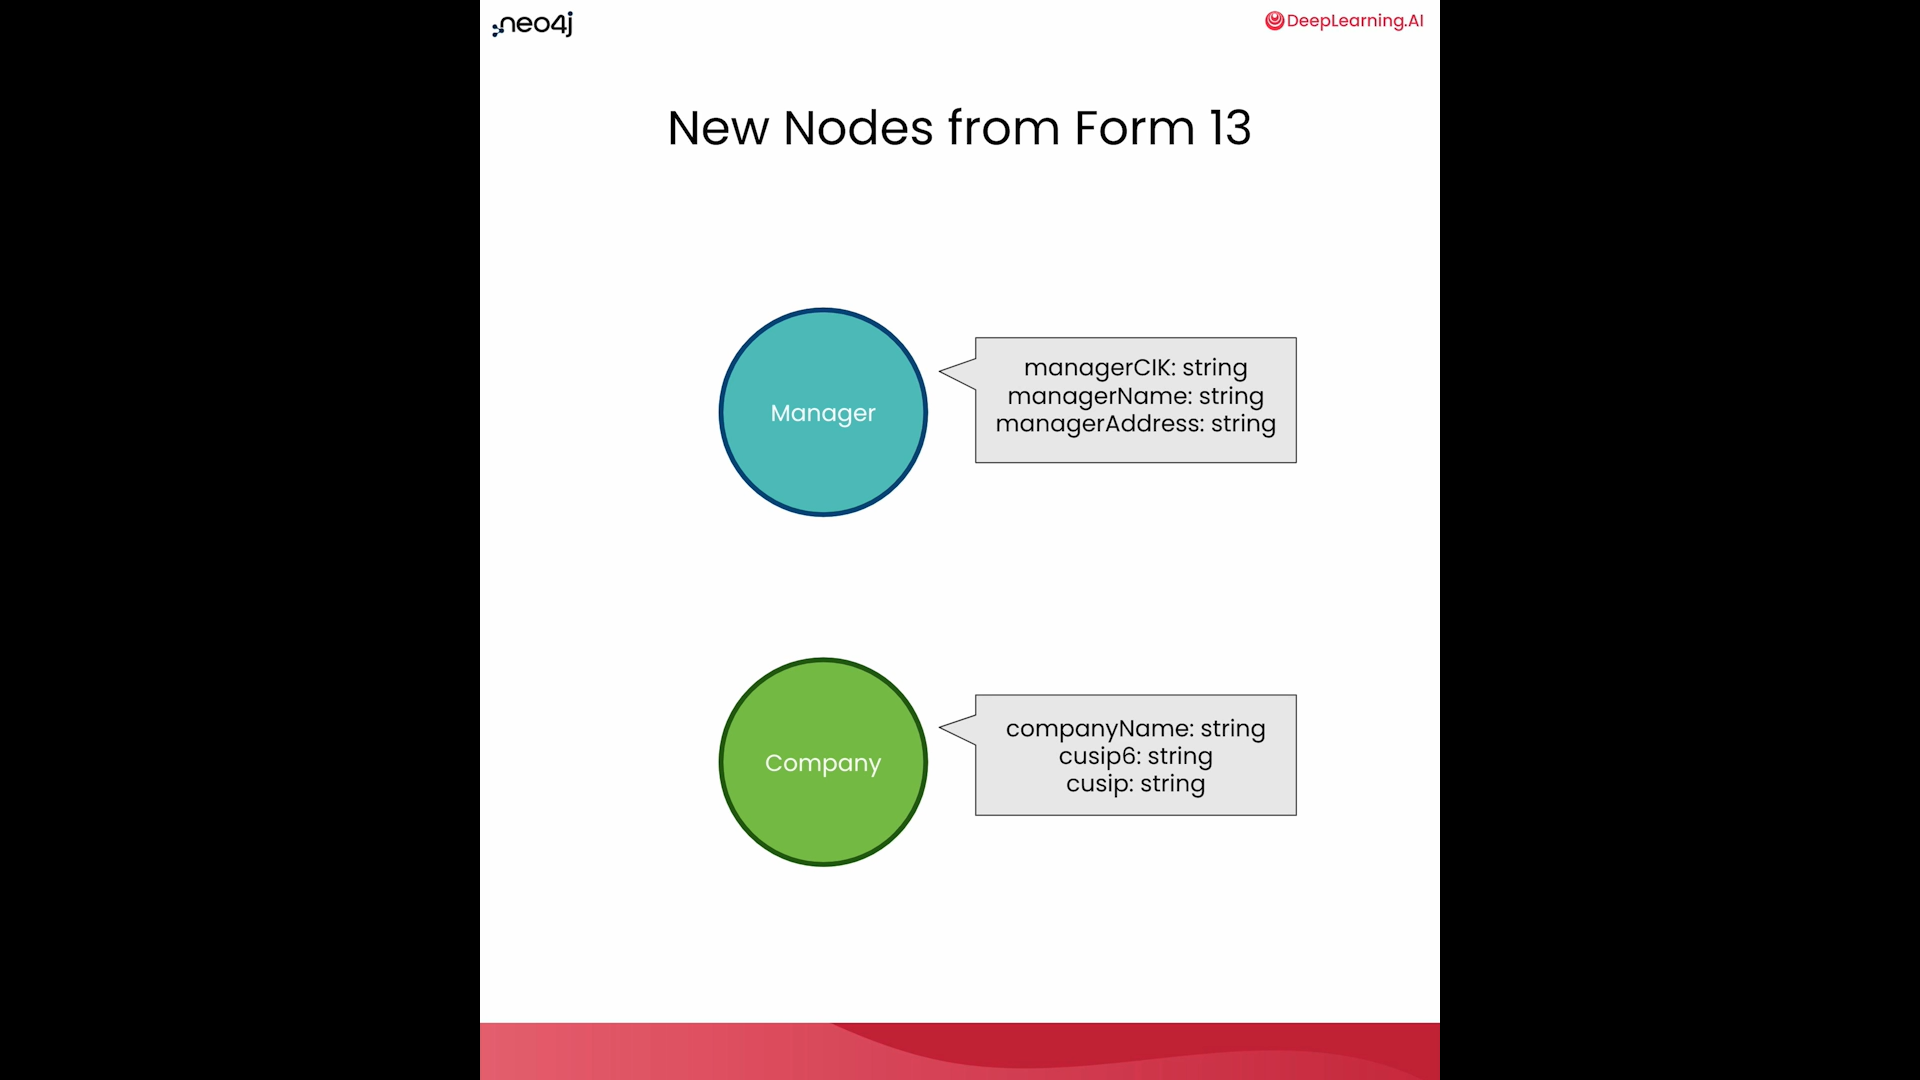

### Create company nodes in the graph
- Use the companies identified in the Form 13s to create `Company` nodes
- For now, there is only one company - NetApp

In [7]:
# work with just the first form fow now
first_form13 = all_form13s[0]

cypher = """
MERGE (com:Company {cusip6: $cusip6})
  ON CREATE
    SET com.companyName = $companyName,
        com.cusip = $cusip
"""

kg.query(cypher, params={
    'cusip6':first_form13['cusip6'], 
    'companyName':first_form13['companyName'], 
    'cusip':first_form13['cusip'] 
})

[]

In [8]:
cypher = """
MATCH (com:Company)
RETURN com LIMIT 1
"""

kg.query(cypher)

[{'com': {'cusip': '64110D104',
   'companyName': 'NETAPP INC',
   'cusip6': '64110D'}}]

- Update the company name to match Form 10-K

Since we have already create Form 10-k Nodes earlier . So we will see whether Netapp name is same as our this dataset 

In [9]:
cypher = """
  MATCH (com:Company), (form:Form)
    WHERE com.cusip6 = form.cusip6
  RETURN com.companyName, form.names
"""

kg.query(cypher)

[{'com.companyName': 'NETAPP INC', 'form.names': ['Netapp Inc', 'NETAPP INC']}]

Since there are some variations in form names and companyName. We will set it as per form.names

In [10]:
cypher = """
  MATCH (com:Company), (form:Form)
    WHERE com.cusip6 = form.cusip6
  SET com.names = form.names
"""

kg.query(cypher)

[]

- Create a `FILED` relationship between the company and the Form-10K node

We are creating this relationship because we can know that this company has filed their form10 k. 

In [11]:
kg.query("""
  MATCH (com:Company), (form:Form)
    WHERE com.cusip6 = form.cusip6
  MERGE (com)-[:FILED]->(form)
""")


[]

### Create manager nodes
- Create a `manager` node for companies that have filed a Form 13 to report their investment in NetApp
- Start with the single manager who filed the first Form 13 in the list

In [12]:
cypher = """
  MERGE (mgr:Manager {managerCik: $managerParam.managerCik})
    ON CREATE
        SET mgr.managerName = $managerParam.managerName,
            mgr.managerAddress = $managerParam.managerAddress
"""

kg.query(cypher, params={'managerParam': first_form13})

[]

In [13]:
kg.query("""
  MATCH (mgr:Manager)
  RETURN mgr LIMIT 1
""")

[{'mgr': {'managerCik': '1000275',
   'managerAddress': 'ROYAL BANK PLAZA, 200 BAY STREET, TORONTO, A6, M5J2J5',
   'managerName': 'Royal Bank of Canada'}}]

- Create a uniquness constraint to avoid duplicate managers

In [14]:
kg.query("""
CREATE CONSTRAINT unique_manager 
  IF NOT EXISTS
  FOR (n:Manager) 
  REQUIRE n.managerCik IS UNIQUE
""")

[]

- Create a fulltext index of manager names to enable text search

Full text index allows searching based on similar looking strings

In [21]:
kg.query("""
CREATE FULLTEXT INDEX fullTextManagerNames
  IF NOT EXISTS
  FOR (mgr:Manager) 
  ON EACH [mgr.managerName]
""")


[]

In [22]:
kg.query("""
  CALL db.index.fulltext.queryNodes("fullTextManagerNames", 
      "royal bank") YIELD node, score
  RETURN node.managerName, score
""")

[{'node.managerName': 'Royal Bank of Canada', 'score': 3.7019896507263184},
 {'node.managerName': 'Royal Fund Management, LLC',
  'score': 2.2780675888061523},
 {'node.managerName': 'ROYAL LONDON ASSET MANAGEMENT LTD',
  'score': 2.063053607940674},
 {'node.managerName': 'AMALGAMATED BANK', 'score': 1.798886775970459},
 {'node.managerName': 'COMMERCE BANK', 'score': 1.798886775970459},
 {'node.managerName': 'UMB Bank, n.a.', 'score': 1.5895916223526},
 {'node.managerName': 'Norinchukin Bank, The', 'score': 1.5895916223526},
 {'node.managerName': 'HUNTINGTON NATIONAL BANK', 'score': 1.5895916223526},
 {'node.managerName': 'Swiss National Bank', 'score': 1.5895916223526},
 {'node.managerName': 'AMERICAN NATIONAL BANK', 'score': 1.5895916223526},
 {'node.managerName': 'TORONTO DOMINION BANK', 'score': 1.5895916223526},
 {'node.managerName': 'Bangor Savings Bank', 'score': 1.5895916223526},
 {'node.managerName': 'Czech National Bank', 'score': 1.5895916223526},
 {'node.managerName': 'DEUTS

- Create nodes for all companies that filed a Form 13

In [18]:
cypher = """
  MERGE (mgr:Manager {managerCik: $managerParam.managerCik})
    ON CREATE
        SET mgr.managerName = $managerParam.managerName,
            mgr.managerAddress = $managerParam.managerAddress
"""
# loop through all Form 13s
for form13 in all_form13s:
  kg.query(cypher, params={'managerParam': form13 })

In [23]:
kg.query("""
    MATCH (mgr:Manager) 
    RETURN count(mgr)
""")

[{'count(mgr)': 561}]

### Create relationships between managers and companies
- Match companies with managers based on data in the Form 13
- Create an `OWNS_STOCK_IN` relationship between the manager and the company
- Start with the single manager who filed the first Form 13 in the list

In [24]:
cypher = """
  MATCH (mgr:Manager {managerCik: $investmentParam.managerCik}), 
        (com:Company {cusip6: $investmentParam.cusip6})
  RETURN mgr.managerName, com.companyName, $investmentParam as investment
"""

kg.query(cypher, params={ 
    'investmentParam': first_form13 
})

[{'mgr.managerName': 'Royal Bank of Canada',
  'com.companyName': 'NETAPP INC',
  'investment': {'shares': '842850',
   'source': 'https://sec.gov/Archives/edgar/data/1000275/0001140361-23-039575.txt',
   'managerName': 'Royal Bank of Canada',
   'managerAddress': 'ROYAL BANK PLAZA, 200 BAY STREET, TORONTO, A6, M5J2J5',
   'value': '64395000000.0',
   'cusip6': '64110D',
   'cusip': '64110D104',
   'reportCalendarOrQuarter': '2023-06-30',
   'companyName': 'NETAPP INC',
   'managerCik': '1000275'}}]

Now you can find Manager Node and Compant they are invested in

OWNS_STOCK_IN have reportCalendarOrQuarter property 
value and share will also be added once owns is created

In [25]:
cypher = """
MATCH (mgr:Manager {managerCik: $ownsParam.managerCik}), 
        (com:Company {cusip6: $ownsParam.cusip6})
        
MERGE (mgr)-[owns:OWNS_STOCK_IN { 
    reportCalendarOrQuarter: $ownsParam.reportCalendarOrQuarter
}]->(com)
ON CREATE
    SET owns.value  = toFloat($ownsParam.value), 
        owns.shares = toInteger($ownsParam.shares)
RETURN mgr.managerName, owns.reportCalendarOrQuarter, com.companyName
"""

kg.query(cypher, params={ 'ownsParam': first_form13 })

[{'mgr.managerName': 'Royal Bank of Canada',
  'owns.reportCalendarOrQuarter': '2023-06-30',
  'com.companyName': 'NETAPP INC'}]

In [26]:
kg.query("""
MATCH (mgr:Manager {managerCik: $ownsParam.managerCik})
-[owns:OWNS_STOCK_IN]->
        (com:Company {cusip6: $ownsParam.cusip6})
RETURN owns { .shares, .value }
""", params={ 'ownsParam': first_form13 })

[{'owns': {'shares': 842850, 'value': 64395000000.0}}]

- Create relationships between all of the managers who filed Form 13s and the company

In [27]:
cypher = """
MATCH (mgr:Manager {managerCik: $ownsParam.managerCik}), 
        (com:Company {cusip6: $ownsParam.cusip6})
MERGE (mgr)-[owns:OWNS_STOCK_IN { 
    reportCalendarOrQuarter: $ownsParam.reportCalendarOrQuarter 
    }]->(com)
  ON CREATE
    SET owns.value  = toFloat($ownsParam.value), 
        owns.shares = toInteger($ownsParam.shares)
"""

#loop through all Form 13s
for form13 in all_form13s:
  kg.query(cypher, params={'ownsParam': form13 })

In [28]:
cypher = """
  MATCH (:Manager)-[owns:OWNS_STOCK_IN]->(:Company)
  RETURN count(owns) as investments
"""

kg.query(cypher)

[{'investments': 561}]

### Schema 

Till now we have added multiple things . Lets see schema

Nodes :
- Chunks 
- Form
- Company 
- Manager

Relationships 
- (:Chunk)-[:NEXT]->(:Chunk),
- (:Chunk)-[:PART_OF]->(:Form),
- (:Form)-[:SECTION]->(:Chunk),
- (:Company)-[:FILED]->(:Form),
- (:Manager)-[:OWNS_STOCK_IN]->(:Company)

In [29]:
kg.refresh_schema()
print(textwrap.fill(kg.schema, 60))

Node properties are the following: Chunk {textEmbedding:
LIST, f10kItem: STRING, chunkSeqId: INTEGER, text: STRING,
cik: STRING, cusip6: STRING, names: LIST, formId: STRING,
source: STRING, chunkId: STRING},Form {cusip6: STRING,
names: LIST, formId: STRING, source: STRING},Company
{cusip6: STRING, names: LIST, companyName: STRING, cusip:
STRING},Manager {managerName: STRING, managerCik: STRING,
managerAddress: STRING} Relationship properties are the
following: SECTION {f10kItem: STRING},OWNS_STOCK_IN {shares:
INTEGER, reportCalendarOrQuarter: STRING, value: FLOAT} The
relationships are the following: (:Chunk)-[:NEXT]-
>(:Chunk),(:Chunk)-[:PART_OF]->(:Form),(:Form)-[:SECTION]-
>(:Chunk),(:Company)-[:FILED]->(:Form),(:Manager)-
[:OWNS_STOCK_IN]->(:Company)


### Determine the number of investors
- Start by finding a form 10-K chunk, and save to use in subsequent queries

In [30]:
cypher = """
    MATCH (chunk:Chunk)
    RETURN chunk.chunkId as chunkId LIMIT 1
    """

chunk_rows = kg.query(cypher)
print(chunk_rows)

[{'chunkId': '0000950170-23-027948-item1-chunk0000'}]


In [31]:
chunk_first_row = chunk_rows[0]
print(chunk_first_row)

{'chunkId': '0000950170-23-027948-item1-chunk0000'}


In [32]:
ref_chunk_id = chunk_first_row['chunkId']
ref_chunk_id

'0000950170-23-027948-item1-chunk0000'

- Build up path from Form 10-K chunk to companies and managers

In [33]:
cypher = """
    MATCH (:Chunk {chunkId: $chunkIdParam})-[:PART_OF]->(f:Form)
    RETURN f.source
    """

kg.query(cypher, params={'chunkIdParam': ref_chunk_id})

[{'f.source': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}]

In [34]:
cypher = """
MATCH (:Chunk {chunkId: $chunkIdParam})-[:PART_OF]->(f:Form),
    (com:Company)-[:FILED]->(f)
RETURN com.companyName as name
"""

kg.query(cypher, params={'chunkIdParam': ref_chunk_id})

[{'name': 'NETAPP INC'}]

In [36]:
cypher = """
MATCH (:Chunk {chunkId: $chunkIdParam})-[:PART_OF]->(f:Form),
        (com:Company)-[:FILED]->(f),
        (mgr:Manager)-[:OWNS_STOCK_IN]->(com)
RETURN com.companyName, 
        count(mgr.managerName) as numberOfinvestors 
LIMIT 1
"""

kg.query(cypher, params={
    'chunkIdParam': ref_chunk_id
})

### This type of search is not possible with vector search

[{'com.companyName': 'NETAPP INC', 'numberOfinvestors': 561}]

### Use queries to build additional context for LLM
- Create sentences that indicate how much stock a manager has invested in a company

In [37]:
cypher = """
    MATCH (:Chunk {chunkId: $chunkIdParam})-[:PART_OF]->(f:Form),
        (com:Company)-[:FILED]->(f),
        (mgr:Manager)-[owns:OWNS_STOCK_IN]->(com)
    RETURN mgr.managerName + " owns " + owns.shares + 
        " shares of " + com.companyName + 
        " at a value of $" + 
        apoc.number.format(toInteger(owns.value)) AS text
    LIMIT 10
    """
kg.query(cypher, params={
    'chunkIdParam': ref_chunk_id
})

[{'text': 'CSS LLC/IL owns 12500 shares of NETAPP INC at a value of $955,000,000'},
 {'text': 'BOKF, NA owns 40774 shares of NETAPP INC at a value of $3,115,134,000'},
 {'text': 'BANK OF NOVA SCOTIA owns 18676 shares of NETAPP INC at a value of $1,426,847,000'},
 {'text': 'Jefferies Financial Group Inc. owns 23200 shares of NETAPP INC at a value of $1,772,480,000'},
 {'text': 'DEUTSCHE BANK AG\\ owns 929854 shares of NETAPP INC at a value of $71,040,845,000'},
 {'text': 'TORONTO DOMINION BANK owns 183163 shares of NETAPP INC at a value of $13,984,000'},
 {'text': 'STATE BOARD OF ADMINISTRATION OF FLORIDA RETIREMENT SYSTEM owns 265756 shares of NETAPP INC at a value of $20,303,759,000'},
 {'text': 'NISA INVESTMENT ADVISORS, LLC owns 67848 shares of NETAPP INC at a value of $5,183,587,000'},
 {'text': 'ONTARIO TEACHERS PENSION PLAN BOARD owns 7290 shares of NETAPP INC at a value of $556,956,000'},
 {'text': 'STATE STREET CORP owns 9321206 shares of NETAPP INC at a value of $712,140,138,0

In [38]:
results = kg.query(cypher, params={
    'chunkIdParam': ref_chunk_id
})
print(textwrap.fill(results[0]['text'], 60))

CSS LLC/IL owns 12500 shares of NETAPP INC at a value of
$955,000,000


- Create a plain Question Answer chain
- Similarity search only, no augmentation by Cypher Query 

In [39]:
vector_store = Neo4jVector.from_existing_graph(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name=VECTOR_INDEX_NAME,
    node_label=VECTOR_NODE_LABEL,
    text_node_properties=[VECTOR_SOURCE_PROPERTY],
    embedding_node_property=VECTOR_EMBEDDING_PROPERTY,
)
# Create a retriever from the vector store
retriever = vector_store.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
plain_chain = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=retriever
)

- Create a second QA chain
- Augment similarity search using sentences found by the investment query above


In this query - node will come from vector search . It will give us a node that it found that is similar to the questions that was asked .

Once we get that node . Our below cypher query will run

In [40]:
investment_retrieval_query = """
MATCH (node)-[:PART_OF]->(f:Form),
    (f)<-[:FILED]-(com:Company),
    (com)<-[owns:OWNS_STOCK_IN]-(mgr:Manager)
WITH node, score, mgr, owns, com 
    ORDER BY owns.shares DESC LIMIT 10
WITH collect (
    mgr.managerName + 
    " owns " + owns.shares + 
    " shares in " + com.companyName + 
    " at a value of $" + 
    apoc.number.format(toInteger(owns.value)) + "." 
) AS investment_statements, node, score
RETURN apoc.text.join(investment_statements, "\n") + 
    "\n" + node.text AS text,
    score,
    { 
      source: node.source
    } as metadata
"""

In [41]:
vector_store_with_investment = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="neo4j",
    index_name=VECTOR_INDEX_NAME,
    text_node_property=VECTOR_SOURCE_PROPERTY,
    retrieval_query=investment_retrieval_query,
)

# Create a retriever from the vector store
retriever_with_investments = vector_store_with_investment.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
investment_chain = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=retriever_with_investments
)

- Compare the outputs!

In [42]:
question = "In a single sentence, tell me about Netapp."

In [43]:
plain_chain(
    {"question": question},
    return_only_outputs=True,
)

{'answer': 'NetApp is a global cloud-led, data-centric software company that provides customers the freedom to manage applications and data across hybrid multicloud environments. \n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

In [44]:
investment_chain(
    {"question": question},
    return_only_outputs=True,
)

{'answer': 'NetApp is a global cloud-led, data-centric software company that focuses on enterprise storage and data management, cloud storage, and cloud operations markets, providing solutions for hybrid multicloud environments and intelligent data management software.\n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

- The LLM didn't make use of the investor information since the question didn't ask about investors
- Change the question and ask again

In [45]:
question = "In a single sentence, tell me about Netapp investors."

In [46]:
plain_chain(
    {"question": question},
    return_only_outputs=True,
)

{'answer': 'Netapp investors are diverse and include global enterprises, local businesses, and government installations who look to NetApp and its ecosystem of partners to maximize the business value of their IT and cloud investments.\n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

In [47]:
investment_chain(
    {"question": question},
    return_only_outputs=True,
)

{'answer': 'Netapp investors include VANGUARD GROUP INC, BlackRock Inc., and PRIMECAP MANAGEMENT CO/CA/.\n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

### Try for yourself

- Try changing the query above to retrieve other information
- Try asking different questions
- Note, if you change the Cypher query, you'll need to reset the retriever and QA chain